In [2]:
import pandas as pd
import spacy
import nltk
import multiprocessing
from pandarallel import pandarallel
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
df = pd.read_csv('/Users/miaoli/Desktop/Uchi/assignments/spring_24/ds for algorithimic marketing/project/winemag-data_first150k.csv')
df.head()

Unnamed: 0 country                                        description  \
0           0      US  This tremendous 100% varietal wine hails from ...   
1           1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2           2      US  Mac Watson honors the memory of a wine once ma...   
3           3      US  This spent 20 months in 30% new French oak, an...   
4           4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65.0          Oregon   
4                            La Brûlade      95   66.0        Provence   

            region_1           region_2             variety  \
0        Napa Valley               Napa  Cabernet Sauvignon   
1               Toro                NaN       Tinta de Toro   
2     Knights Valley             Sonoma     Sauvignon Blanc   
3  Willamette Valley  Willamette Valley          Pinot Noir   
4             Bandol                NaN  Provence red blend   

                    winery  
0                    Heitz  
1  Bodega Carmen Rodríguez  
2                 Macauley  
3                    Ponzi  
4     Domaine de la Bégude

In [5]:
red_blend = ["Cabernet Sauvignon-Syrah", "Cabernet Sauvignon-Syrah", "Cabernet Sauvignon-Merlot", "Syrah-Cabernet Sauvignon", "Merlot-Cabernet Sauvignon", "Cabernet Franc-Merlot", "Syrah-Mourvèdre", "Syrah-Grenache", "Grenache-Syrah", "Cabernet Blend", "Syrah-Merlot", "Cabernet Blend", "Cabernet Franc-Malbec", "Grenache Blend", "Cabernet Sauvignon-Malbec", "Syrah-Cabernet Franc", "Merlot-Petite Verdot", "Grenache-Mourvèdre", "Shiraz-Cabernet Sauvignon", "Grenache-Shiraz", "Cabernet Sauvignon-Shiraz",
 "Malbec-Syrah", "Merlot-Malbec", "Merlot-Syrah", "Malbec-Merlot","cabernet sauvignon", "pinot noir", "red blend", "bordeaux blend", "rhone blend", "zinfandel"]

red_blend_list = [wine.lower() for wine in red_blend]

In [6]:
default_stopwords = set(nltk.corpus.stopwords.words('english'))
wnl = nltk.WordNetLemmatizer()
def tokenize_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    txt = [word.lower() for word in tokens if word.isalpha()]
    words_lc = [word for word in txt if word.lower() not in default_stopwords]
    lst = [wnl.lemmatize(token) for token in words_lc]

    return lst

def set_ngram(clean_token, n):
    return nltk.ngrams(clean_token, n)

def point_class(point):
    if point < 85:
        return 'Good'
    elif point < 90:
        return 'Very Good'
    elif point < 95:
        return 'Outstanding'
    else:
        return 'Classic'
    
def filter_variety(variety):
    variety = variety.lower()
    if variety in red_blend_list or 'red blend' in variety:
        return 1
    else:
        return 0

In [7]:
df.loc[:, 'filtered_variety'] = df['variety'].parallel_apply(filter_variety)
mask = (df['country'] == 'US') & (df['filtered_variety'] == 1)
us_red = df.loc[mask, :]

# Modify the 'point_class' column in us_red using the loc method
us_red.loc[:, 'point_class'] = us_red['points'].parallel_apply(point_class)

/var/folders/rs/dwj3n8716t593gn_r4x21y0r0000gn/T/ipykernel_40108/3614698371.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_red.loc[:, 'point_class'] = us_red['points'].parallel_apply(point_class)


### NLP ##

In [ ]:
us_red.loc[:,'des_token'] = us_red.loc[:,'description'].parallel_apply(tokenize_text)

/var/folders/rs/dwj3n8716t593gn_r4x21y0r0000gn/T/ipykernel_34874/2370883669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_red.loc[:,'des_token'] = us_red.loc[:,'description'].parallel_apply(tokenize_text)


In [ ]:
words = [word for list in us_red.loc[:,'des_token'].to_list() for word in list]
fdist = nltk.FreqDist(words)
fdist.most_common(15)

[('flavor', 19432),
 ('wine', 15716),
 ('cherry', 14791),
 ('fruit', 10396),
 ('tannin', 9504),
 ('blackberry', 7757),
 ('dry', 7441),
 ('oak', 6439),
 ('cabernet', 6194),
 ('black', 6191),
 ('finish', 5975),
 ('pinot', 5740),
 ('ripe', 5167),
 ('currant', 5140),
 ('rich', 5126)]

In [ ]:
us_red.loc[:,'2_gram'] = us_red.des_token.parallel_apply(lambda x: list(nltk.ngrams(x,2)))

/var/folders/rs/dwj3n8716t593gn_r4x21y0r0000gn/T/ipykernel_34874/3780518165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_red.loc[:,'2_gram'] = us_red.des_token.parallel_apply(lambda x: list(nltk.ngrams(x,2)))


<Axes: xlabel='points', ylabel='Count'>

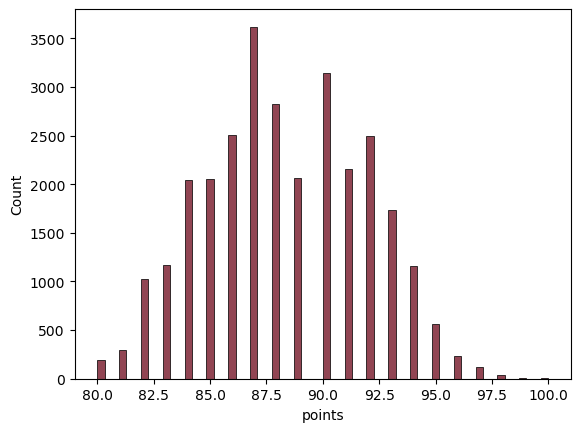

In [8]:
#removing points higher than 100, the highest possible points
clean_df = us_red.loc[us_red.loc[:,'points']<=100, :]
clean_df.describe()

sns.histplot(clean_df.points, color = '#6D071A')

<Axes: xlabel='price', ylabel='Count'>

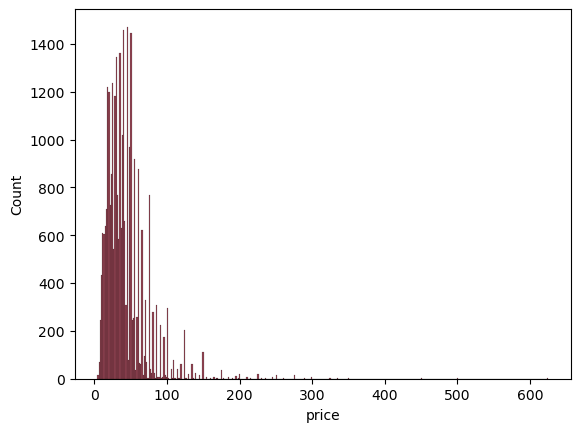

In [ ]:
sns.histplot(clean_df.price, color = '#6D071A')
# df.price.describe()

In [ ]:
words = [word for row in us_red['2_gram'].to_list() for word in row]
fdist_2 = nltk.FreqDist(words)
fdist_2.most_common(15)

[(('pinot', 'noir'), 2695),
 (('cabernet', 'sauvignon'), 2028),
 (('black', 'cherry'), 1935),
 (('black', 'currant'), 1812),
 (('blackberry', 'cherry'), 1804),
 (('raspberry', 'cherry'), 1774),
 (('cherry', 'cola'), 1215),
 (('fruit', 'flavor'), 1190),
 (('cherry', 'raspberry'), 1169),
 (('spice', 'flavor'), 1144),
 (('cherry', 'fruit'), 1108),
 (('blackberry', 'black'), 1101),
 (('flavor', 'blackberry'), 1099),
 (('flavor', 'cherry'), 1047),
 (('smoky', 'oak'), 991)]

In [ ]:
def get_freq_dict(gram2):
    gram2 = dict(fdist_2) 
    gram2_dict = {}
    for key, value in gram2.items():
        key = " ".join(key)
        gram2_dict[key] = value
    return gram2_dict


{'tremendous varietal': 1, 'varietal wine': 6, 'wine hail': 1, 'hail oakville': 1, 'oakville aged': 1, 'aged three': 1, 'three year': 3, 'year oak': 1, 'oak juicy': 1, 'juicy fruit': 1, 'fruit compelling': 1, 'compelling hint': 1, 'hint caramel': 1, 'caramel greet': 1, 'greet palate': 1, 'palate framed': 2, 'framed elegant': 1, 'elegant fine': 2, 'fine tannin': 32, 'tannin subtle': 1, 'subtle minty': 1, 'minty tone': 1, 'tone background': 1, 'background balanced': 1, 'balanced rewarding': 1, 'rewarding start': 1, 'start finish': 7, 'finish year': 1, 'year ahead': 1, 'ahead develop': 1, 'develop nuance': 1, 'nuance enjoy': 1, 'spent month': 4, 'month new': 3, 'new french': 48, 'french oak': 53, 'oak incorporates': 1, 'incorporates fruit': 1, 'fruit ponzi': 1, 'ponzi aurora': 1, 'aurora abetina': 1, 'abetina madrona': 1, 'madrona vineyard': 1, 'vineyard among': 1, 'among others': 1, 'others aromatic': 1, 'aromatic dense': 1, 'dense toasty': 1, 'toasty deftly': 1, 'deftly blend': 1, 'blen

{'bergström made': 1, 'made shea': 1, 'shea designate': 2, 'designate since': 1, 'since intent': 1, 'intent showcasing': 1, 'showcasing pretty': 1, 'pretty style': 2, 'style vineyard': 1, 'vineyard lovely': 3, 'lovely aromatics': 11, 'aromatics grape': 1, 'grape jelly': 1, 'jelly rose': 1, 'rose petal': 154, 'petal plum': 1, 'plum nose': 2, 'nose complex': 6, 'complex run': 1, 'run red': 1, 'red fruit': 244, 'fruit mouth': 4, 'mouth streak': 1, 'streak cola': 16, 'cola brown': 2, 'brown sugar': 36, 'sugar come': 2, 'come generous': 1, 'generous finish': 2, 'focused dense': 1, 'dense intense': 4, 'intense wine': 5, 'wine capture': 12, 'capture essence': 16, 'essence ripe': 3, 'ripe raspberry': 61, 'raspberry aged': 1, 'aged new': 57, 'new french': 237, 'french oak': 250, 'oak got': 2, 'got strong': 1, 'strong vein': 2, 'vein coffee': 2, 'coffee mocha': 6, 'mocha flavor': 50, 'flavor broaden': 1, 'broaden penetrate': 1, 'penetrate finishing': 1, 'finishing highlight': 2, 'highlight cedar

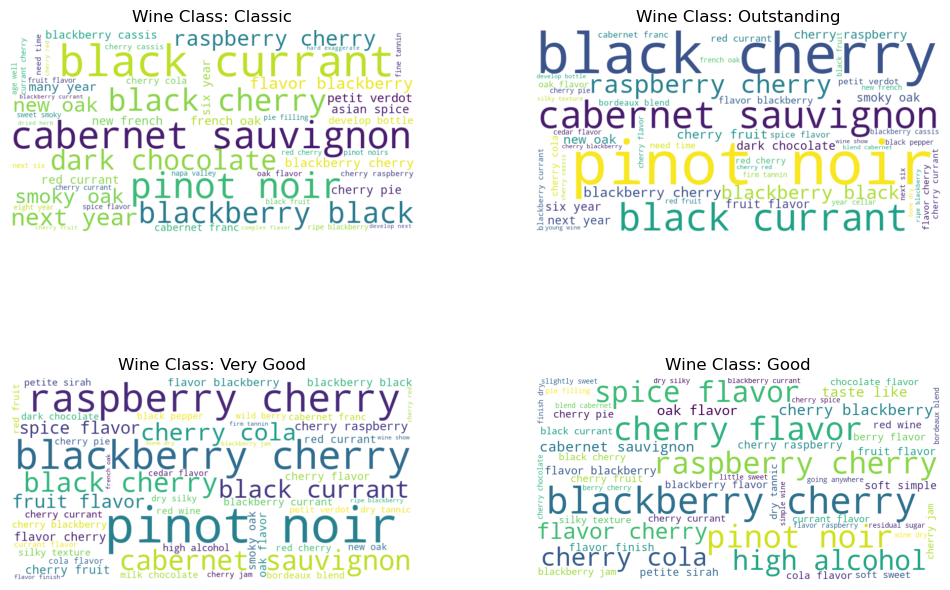

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes list to iterate over each subplot
axes = axes.flatten()

for i, wine_class in enumerate(clean_df['point_class'].unique()):
    class_df = clean_df.loc[clean_df['point_class'] == wine_class, :]
    words = [word for list in class_df['2_gram'].to_list() for word in list]
    fdist_2 = nltk.FreqDist(words)
    gram_dict = get_freq_dict(fdist_2)
    wc = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(gram_dict)

    # Plot the word cloud on the corresponding subplot
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Wine Class: {wine_class}")
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.imshow(wc)

In [ ]:
pd.options.display.max_colwidth = 300
# Set the maximum width for the entire DataFrame to 1000 characters
pd.options.display.width = 300
clean_df.loc[:,['description','des_token','2_gram']].head()

description  \
0   This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has ye...   
3   This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine ...   
8    This re-named vineyard was formerly bottled as deLancellotti. You'll find striking minerality underscoring chunky black fruits. Accents of citrus and graphite comingle, with exceptional midpalate concentration. This is a wine to cellar, though it is already quite enjoyable. Drink now through 2030.   
9   The producer sources from two blocks of the vineyard for this wine—one at a high elevation, which contributes bright acidity. Crunchy cranberry, pomegranate and orange peel flavors surround silky, succulent layers of texture that present as fleshy fruit. That delicately lush flavor has considera...   
11                                         From 18-year-old vines, this supple well-balanced effort blends flavors of mocha, cherry, vanilla and breakfast tea. Superbly integrated and delicious even at this early stage, this wine seems destined for a long and savory cellar life. Drink now through 2028.   

                                                                                                                                                                                                                                                                                                      des_token  \
0                                         [tremendous, varietal, wine, hail, oakville, aged, three, year, oak, juicy, fruit, compelling, hint, caramel, greet, palate, framed, elegant, fine, tannin, subtle, minty, tone, background, balanced, rewarding, start, finish, year, ahead, develop, nuance, enjoy]   
3   [spent, month, new, french, oak, incorporates, fruit, ponzi, aurora, abetina, madrona, vineyard, among, others, aromatic, dense, toasty, deftly, blend, aroma, flavor, toast, cigar, box, blackberry, black, cherry, coffee, graphite, tannin, polished, fine, sheen, frame, finish, loaded, dark, choco...   
8                                                               [vineyard, formerly, bottled, delancellotti, find, striking, minerality, underscoring, chunky, black, fruit, accent, citrus, graphite, comingle, exceptional, midpalate, concentration, wine, cellar, though, already, quite, enjoyable, drink]   
9                                            [producer, source, two, block, vineyard, high, elevation, contributes, bright, acidity, crunchy, cranberry, pomegranate, orange, peel, flavor, surround, silky, succulent, layer, texture, present, fleshy, fruit, delicately, lush, flavor, considerable, length]   
11                                                                                                                 [vine, supple, effort, blend, flavor, mocha, cherry, vanilla, breakfast, tea, superbly, integrated, delicious, even, early, stage, wine, seems, destined, long, savory, cellar, life, drink]   

                                                                                                                                                                                                                                                                                                         2_gram  
0   [(tremendous, varietal), (varietal, wine), (wine, hail), (hail, oakville), (oakville, aged), (aged, three), (three, year), (year, oak), (oak, juicy), (juicy, fruit), (fruit, compelling), (compelling, hint), (hint, caramel), (caramel, greet), (greet, palate), (palate, framed), (framed, elegant), 

Sentiment Analysis

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
def sentiment(label):
    if label == 'Classic':
        return 1
    elif label == 'Good':
        return 0

In [ ]:
clean_df.loc[:,'sent_score'] = clean_df.loc[:,'point_class'].parallel_apply(sentiment)
sent_df = clean_df.loc[~(clean_df.loc[:,'sent_score'].isna()),:]
sent_df.sent_score.value_counts()

0.0    4734
1.0     976
Name: sent_score, dtype: int64

In [ ]:
#have to balanced dataset
def clean_text(token):
    text = " ".join(token)
    return text

classic = sent_df.loc[sent_df.sent_score == 1, :]
good = sent_df.loc[sent_df.sent_score == 0, :]
good_ba = good.sample(1000)

In [ ]:
sent_df = pd.concat((classic, good_ba), ignore_index=True)
sent_df.loc[:,'clean_text'] = sent_df.des_token.apply(clean_text)

In [ ]:
X = sent_df.loc[:,'clean_text']
y = sent_df.loc[:,'sent_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)
print(X_train.shape)
print(X_test.shape)

(1580,)
(396,)


In [ ]:
tfvect = TfidfVectorizer(ngram_range=(2,4))
logreg_tf = LogisticRegression(max_iter=200).fit(tfvect.fit_transform(X_train), y_train)
#predicting
y_pred = logreg_tf.predict(tfvect.transform(X_test))
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred) * 100:.1f}%")
print(classification_report(y_test, y_pred))

Test Accuracy: 92.2%
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92       205
         1.0       0.91      0.93      0.92       191

    accuracy                           0.92       396
   macro avg       0.92      0.92      0.92       396
weighted avg       0.92      0.92      0.92       396



In [ ]:
feature_names = tfvect .get_feature_names_out()
coefs_with_fns = zip(feature_names, logreg_tf.coef_[0])

coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                    columns=['feature', 'coefficient'])

In [ ]:
coefs_with_fns_df.sort_values('coefficient', ascending=True, inplace=True)
coefs_with_fns_df.head(10)

feature  coefficient
12186             cherry flavor    -1.659013
6768          blackberry cherry    -0.924580
5283               berry flavor    -0.914928
58720               soft simple    -0.817385
33607              high alcohol    -0.732436
6811   blackberry cherry flavor    -0.717096
14457               cola flavor    -0.673062
65137                taste like    -0.671813
12006        cherry cola flavor    -0.626051
47210              petite sirah    -0.615358